In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve


In [72]:
df = pd.read_csv('../data/loan_data.csv')

In [73]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

In [74]:
df['fully_paid'] = 1 - df.not_fully_paid
df.drop('not_fully_paid', axis=1, inplace=True)

In [75]:
def print_accuracy_results(y_true, y_preds):
    correct_classification = 1 - np.absolute(y_true - y_preds)
    df = pd.DataFrame({'y_values': y_true, 'correct_classification': correct_classification})
    zeros = df[df.y_values == 0]
    ones = df[df.y_values == 1]
    print("The percentage of fully_paid predicted correctly: ",100*ones.correct_classification.sum()/ones.shape[0])
    print("The percentage of not fully_paid predicted correctly: ",100*zeros.correct_classification.sum()/zeros.shape[0])

In [76]:
def print_scores(classifier, X_test, y_test):
    y_preds = classifier.predict(X_test)
    scores = precision_recall_fscore_support(y_preds, y_test, average='binary')
    print("precision score: ",scores[0])
    print("recall score: ", scores[1])
    print("f1 score: ", scores[2])
    print('-'*50)
    print_accuracy_results(y_test, y_preds)

# Splitting the data

In [98]:
X = df.drop('fully_paid', axis = 1)
y = df.fully_paid
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)

# Base Model

In [99]:
numeric_features = X.select_dtypes(exclude='object').columns
cat_features = df.select_dtypes('object').columns

numeric_transformer = Pipeline(steps=[('scalar',StandardScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(drop = 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_features),
    ('cat',cat_transformer,cat_features)])

lr1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('lr_classifier', LogisticRegression(penalty='none'))])

In [100]:
lr1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti',
       'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier', LogisticRegression(penalty='none'))])

In [101]:
print_scores(lr1, X_test, y_test)

precision score:  0.9907235621521335
recall score:  0.8476190476190476
f1 score:  0.913601368691189
--------------------------------------------------
The percentage of fully_paid predicted correctly:  99.07235621521336
The percentage of not fully_paid predicted correctly:  3.678929765886288


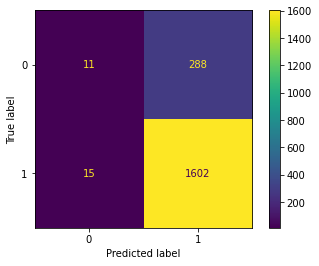

In [102]:
plot_confusion_matrix(lr1, X_test, y_test)

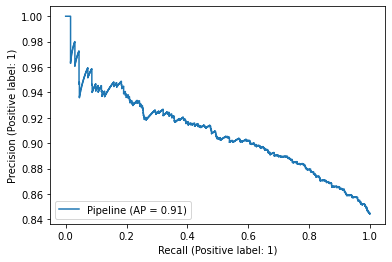

In [103]:
plot_precision_recall_curve(lr1, X_test, y_test)

# Logistic Regression Models with selected features

From the exploratory data analysis, I feel the following four features may effect whether a loan is fully paid.

In [83]:
X2 = df[['credit_policy','purpose','int_rate','revol_util']]
X2_train, X2_test = train_test_split(X2, random_state=675, test_size=0.2)

In [105]:
numeric_features = X2.select_dtypes(exclude='object').columns
cat_features = df.select_dtypes('object').columns

numeric_transformer = Pipeline(steps=[('scalar',StandardScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(drop = 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_features),
    ('cat',cat_transformer,cat_features)])

lr2 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('lr_classifier', LogisticRegression(penalty='none'))])

In [106]:
lr2.fit(X2_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'revol_util'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier', LogisticRegression(penalty='none'))])

In [107]:
print_scores(lr2, X2_test, y_test)

precision score:  0.9987631416202845
recall score:  0.8455497382198953
f1 score:  0.9157924581797562
--------------------------------------------------
The percentage of fully_paid predicted correctly:  99.87631416202845
The percentage of not fully_paid predicted correctly:  1.3377926421404682


Choosing parameters only increased the f1 by a very small amount.  The accuracy decreased.  I want to try regulariztion to avoid overfitting instead of manually selecting features.

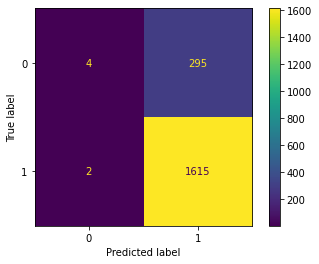

In [108]:
plot_confusion_matrix(lr2 ,X2_test, y_test)

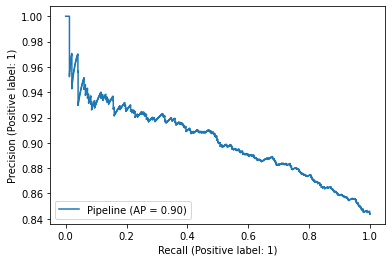

In [109]:
plot_precision_recall_curve(lr2 ,X2_test, y_test)

# Using balanced class weights

In [110]:
lr3 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('lr_classifier', LogisticRegression(penalty='none', class_weight='balanced'))])

In [111]:
lr3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'revol_util'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier',
                 LogisticRegression(class_weight='balanced', penalty='none'))])

In [112]:
print_scores(lr3, X_test, y_test)

precision score:  0.6648113790970934
recall score:  0.8876961189099918
f1 score:  0.7602545968882604
--------------------------------------------------
The percentage of fully_paid predicted correctly:  66.48113790970933
The percentage of not fully_paid predicted correctly:  54.51505016722408


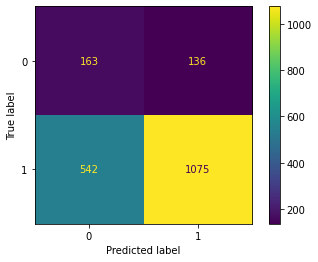

In [113]:
plot_confusion_matrix(lr3 ,X_test, y_test)

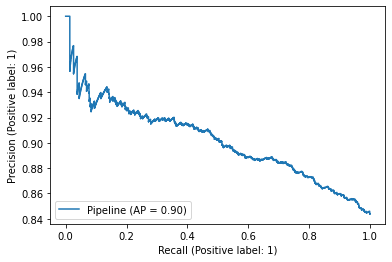

In [114]:
plot_precision_recall_curve(lr3 ,X_test, y_test)

With balanced class weights, more true negatives are predicted but f1 score drops.

# Base model with hyperparameter tuning

# Balanced weights model with hyperparameter tuning

# Handling outliers

In [94]:
X_train = X_train.copy()
X_train['int_rate'] = X_train['int_rate'].apply(lambda x: min([x,0.2]))
# Other outliers as well

In [95]:
lr2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['credit_policy', 'int_rate', 'revol_util'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('lr_classifier', LogisticRegression())])

In [97]:
y_preds = lr2.predict(X_test)
scores = precision_recall_fscore_support(y_preds, y_test, average='binary')
print("precision score: ",scores[0])
print("recall score for: ", scores[1])
print("f1 score for: ", scores[2])

precision score:  0.9987631416202845
recall score for:  0.8455497382198953
f1 score for:  0.9157924581797562


As only 1 feature had outlier values there was no difference when the feature was winsorized